# Recommendations

Lets see if we can make use of the intelligence aquired in the EDA and Modeling notebooks in order to create recomendations for our users

In [1]:
import matplotlib.pyplot as plt
import importlib
from processing import *
from tools import *
from modeling import *
from feature_extraction import *

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 7]

## Simple recommendations

Let's make use of the intelligence that we accumulated on the EDA so that we can compute recommendations for specific users

In [3]:
# Load our datasets
df_orders = pd.read_csv('data/enhanced/df_orders.csv') #.set_index('order_date')
df_products = pd.read_csv('data/enhanced/df_products.csv')

df_order_products_prior = pd.read_csv('data/instacart_2017_05_01/order_products__prior.csv')
# Dataset of most recent orders, ony one order per user. EDA notebook at section: 1.1.5 
df_order_products_train = pd.read_csv('data/instacart_2017_05_01/order_products__train.csv')

# Filter orders right away so code bellow is less verbose
df_orders_prior = df_orders.loc[df_orders['eval_set'] == 'prior']
df_orders_train = df_orders.loc[df_orders['eval_set'] == 'train']
df_orders_test = df_orders.loc[df_orders['eval_set'] == 'test']

/Users/lgarcia/opt/anaconda3/envs/ds-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Selecting some samples.

Lets load the df_users dataframe that we created on the EDA step so that we can user to select some interesting users. We will select a couple of users with a decent (mean-ish) number of orders over time.

In [72]:
df_users = pd.read_csv('data/enhanced/df_users.csv')

In [74]:
df_users.describe()

,user_id,orders_time_interval,orders_per_user
count,206209.000000,206209.000000,206209.000000
mean,103105.000000,173.284377,16.590367
std,59527.555167,100.998967,16.654774
min,1.000000,0.000000,4.000000
25%,51553.000000,89.000000,6.000000
50%,103105.000000,151.000000,10.000000
75%,154657.000000,254.000000,20.000000
max,206209.000000,365.000000,100.000000


The mean of orders_per_user is 16.59. Let's take a three users within the 20 -40 range

In [77]:
df_users_filtered = df_users.loc[(df_users['orders_per_user']>20)&(df_users['orders_per_user']<40)]
df_users_filtered.tail()

,user_id,orders_time_interval,orders_per_user
206186,206187,348.0,35
206196,206197,301.0,24
206199,206200,203.0,24
206200,206201,343.0,33
206201,206202,275.0,23


In [ ]:
# Choose some

sample_users = ['15', '21', ]

### Most often reordered

From section 1.2.6

#### Can we do this for a specific user?
Let's write a method that will receive a user id and will return an order list that will contain the products that the user will most likely reorder. This functionality will be part of our final recommender system that will be formalized in the next notebook.

In [6]:
sample_user_id = 56463 # 79431 (39612) , 56463 (8859)

In [7]:
def products_most_likely_tb_reordered(user_id, df_orders_prior):
    df_tmp = df_order_products_prior.merge(df_orders_prior, how='left', on='order_id').groupby(['user_id']).get_group(user_id)
    df_tmp2 = df_tmp.groupby(['product_id'])
    df_tmp2 = df_tmp2.agg(proportion_reordered=('reordered', 'mean'), product_count=('add_to_cart_order', 'count')).reset_index()
    df_tmp2 = df_tmp2.merge(df_products, how='left')
    df_tmp2 = df_tmp2.sort_values(by=['proportion_reordered'], ascending=False)
    return df_tmp2

(207, 9)

,product_id,proportion_reordered,product_count,product_name,aisle_id,department_id,orders_per_product_train,orders_per_product_prior,product_name_encoded
93,19731,0.973684,38,Organic Orange Juice With Calcium & Vitamin D,31,7,110.0,3136.0,organicorangejuicewithcalciumvitamind_19731
44,8859,0.972973,37,Natural Spring Water,115,7,950.0,19518.0,naturalspringwater_8859
157,37664,0.970588,34,Organic Sliced Provalone Cheese,21,16,94.0,1982.0,organicslicedprovalonecheese_37664
20,4357,0.969697,33,Organic Chocolate Almondmilk Pudding,71,16,144.0,3498.0,organicchocolatealmondmilkpudding_4357
66,15455,0.967742,31,Organic Extra Virgin Oil Olive,19,13,53.0,1889.0,organicextravirginoilolive_15455
104,22963,0.966667,30,Organic Roasted Turkey Breast,96,20,1123.0,28384.0,organicroastedturkeybreast_22963
137,34065,0.965517,29,"Tomatoes, Crushed, Organic",81,15,34.0,1324.0,tomatoescrushedorganic_34065
115,27509,0.961538,26,Organic Seasoned Yukon Select Potatoes Hashed ...,129,1,175.0,5413.0,organicseasonedyukonselectpotatoeshashedbrowns...
48,9896,0.960000,25,Uncured Applewood Smoked Bacon,106,12,28.0,1137.0,uncuredapplewoodsmokedbacon_9896
179,43560,0.958333,24,"Crackers, Oyster",78,19,10.0,305.0,crackersoyster_43560


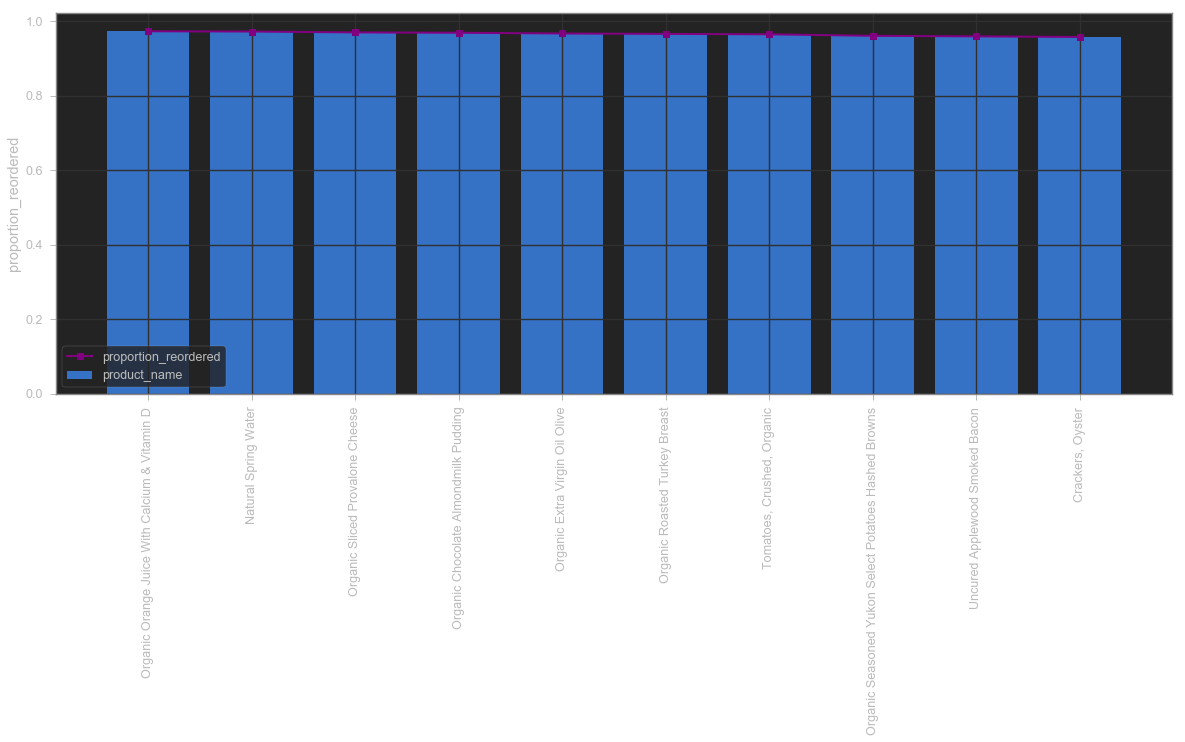

In [8]:
df_most_likely_products = products_most_likely_tb_reordered(sample_user_id)
df_most_likely_products.shape
df_most_likely_products.head(10)
create_bar_chart(df_most_likely_products_2['product_name'][:10], df_most_likely_products_2['proportion_reordered'][:10], 'product_name', 'proportion_reordered')

In [9]:
df_orders_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_date,week_of_year,product_sequences
131209,2806644,178467,prior,1,2,0,0.0,2016-01-01 00:00:00,53,organicbabyspinach_21903 seedlessredgrapes_492...
131210,22120,36713,prior,1,0,0,0.0,2016-01-01 00:00:00,53,basilpesto_12206 supremelyspicyhummus_15923 or...
131211,2455270,36705,prior,1,0,0,0.0,2016-01-01 00:00:00,53,organicgreencabbage_47734 unsweetenedalmondmil...
131212,1995532,167516,prior,1,0,0,0.0,2016-01-01 00:00:00,53,cornchips_11576 organicstrawberries_21137 orga...
131213,46045,29128,prior,1,1,0,0.0,2016-01-01 00:00:00,53,hassavocados_12341


## Time based recommendations

In this section we will make use of the product sequences that correspond to each one of the orders in order to figure out what products are trending in a specific slice of time. For example for a specific month we can make use of Sklearn's CountVectorizer in order to convert a collection our collection of product sequences (as sentences) into a matrix of product (token) counts. The we will use TfidfTransformer¶ in order to transform the product count matrix into a tfidf representation. In this last representation each product sequence will be a row in the matrix and each entry will be the number of times each element in the vocabulary happens in the context of each specific order (product sequence.) 

### Month
Lets do it for a month

In [94]:
sample_month = '11'
# sample_product_id = 8859 # Bulgarian yogurth

In [95]:
def recommend_product_for_month(month_int, df_orders_prior):
    print('Recomending products for month: {}'.format(str(month)))
    df_orders_month = get_orders_in_month(df_orders_prior.set_index('order_date'), str(month_int))
    print('Processing data for {} orders'.format(df_orders_month.shape[0]))
    sequences = list(df_orders_month['product_sequences'].values)
    print('Creating Count vectorizer ... ')
    count_model, X = count_vectorizer(sequences)
    print(count_model)
    df_weights = tfidf_transformer(X, count_model)
    return df_weights

In [96]:
%%time
df_monthly_recommendations = recommend_product_for_month(sample_month, df_orders_prior)
print('\n')

Recomending products for month: 11
Processing data for 1638963 orders
Creating Count vectorizer ... 
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


CPU times: user 27.6 s, sys: 1.28 s, total: 28.9 s
Wall time: 23.2 s


In [97]:
df_monthly_recommendations.head(10)

,product,weight
3547,banana_24852,0.020553
3356,bagoforganicbananas_13176,0.020379
31194,organicstrawberries_21137,0.013814
28103,organicbabyspinach_21903,0.013078
29552,organichassavocado_47209,0.012162
31749,organicwholemilk_27845,0.009784
28068,organicavocado_47766,0.009106
41869,strawberries_16797,0.009026
30619,organicraspberries_27966,0.008925
21814,largelemon_47626,0.008798


### Week
Lets do it for a week

In [56]:
sample_week = 5

In [47]:
def recommend_product_for_week(week_int, df_orders_prior):
    print('Recomending products for week: {}'.format(str(week_int)))
    df_orders_week = get_orders_in_week(df_orders_prior, week_int)
    print('Processing data for {} orders'.format(df_orders_week.shape[0]))
    sequences = list(df_orders_week['product_sequences'].values)
    print('Creating Count vectorizer ... ')
    count_model, X = count_vectorizer(sequences)
    print(count_model)
    df_weights = tfidf_transformer(X, count_model)
    return df_weights

In [48]:
df_weekly_recommendations = recommend_product_for_week(sample_week, df_orders_prior)

Recomending products for week: 5
Processing data for 102938 orders
Creating Count vectorizer ... 
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [49]:
df_weekly_recommendations.head(10)

,product,weight
2587,banana_24852,0.018367
2437,bagoforganicbananas_13176,0.015621
23354,organicstrawberries_21137,0.012673
20806,organicbabyspinach_21903,0.011780
20775,organicavocado_47766,0.010322
21999,organichassavocado_47209,0.009188
31412,strawberries_16797,0.008182
16125,largelemon_47626,0.007356
16887,limes_26209,0.007342
23815,organicwholemilk_27845,0.007037


### Day
Lets do it for a day

In [82]:
df_orders_day = get_orders_in_day(df_orders_prior, str(sample_month), str(sample_day))
df_orders_day.head()

2016-11-13 00:00:00
2016-11-13 23:00:00


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,week_of_year,product_sequences
order_date,,,,,,,,,
2016-11-13 00:00:00,2798688,132282,prior,20,1,0,12.0,45,organicgalaapples_37646 chocolatedarkchocolate...
2016-11-13 00:00:00,2076293,74015,prior,16,2,0,12.0,45,organicgalaapples_37646 authenticfrenchbrioche...
2016-11-13 00:00:00,2739973,88468,prior,24,3,0,12.0,45,coffeelowfatyogurt_47204 originalflavorinstant...
2016-11-13 00:00:00,1405045,9514,prior,21,1,0,12.0,45,wholewheattandoorinaan_7649 goatcheesecrumbles...
2016-11-13 00:00:00,1319177,190012,prior,31,5,0,12.0,45,organicwholemilk_31720 purelyosorganiccereal_3...


In [90]:
sample_day = '13'

In [91]:
def recommend_product_for_day(day_int, month_int, df_orders_prior):
    print('Recomending products for day : {} in month: {}'.format(str(day_int), str(month_int)))
    df_orders_day = get_orders_in_day(df_orders_prior, str(month_int), str(day_int))
    print('Processing data for {} orders'.format(df_orders_day.shape[0]))
    sequences = list(df_orders_day['product_sequences'].values)
    print('Creating Count vectorizer ... ')
    count_model, X = count_vectorizer(sequences)
    print(count_model)
    df_weights = tfidf_transformer(X, count_model)
    return df_weights

In [92]:
df_daily_recommendations = recommend_product_for_day(sample_day, sample_month, df_orders_prior)

Recomending products for day : 13 and month: 11
2016-11-13 00:00:00
2016-11-13 23:00:00
Processing data for 34737 orders
Creating Count vectorizer ... 
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [93]:
df_daily_recommendations.head(10)

,product,weight
1787,banana_24852,0.020336
1674,bagoforganicbananas_13176,0.019850
14681,organicbabyspinach_21903,0.013929
16818,organicstrawberries_21137,0.013186
15666,organichassavocado_47209,0.011535
14655,organicavocado_47766,0.009934
17203,organicwholemilk_27845,0.009820
22614,strawberries_16797,0.009506
11398,largelemon_47626,0.009328
16410,organicraspberries_27966,0.008635


Observations

## Products frequently bought together

In this section we will explore the possibility of identifying the products that are more often bought along side other products. For this we will use again Sklearn's CountVectorizer  from which we will then obtain a co-ocurrence matrix for our products. This matrix will allow us to know which products (and how many times) where bought alongside other products within the same orders.  

In [62]:
df_orders_train.head()
sample_products = ['organicsoytempeh_37147', 'size5cruisersdiaperssuperpack_38365', 'proseccosparklingwine_37923']

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_date,week_of_year,product_sequences
0,2236879,30088,train,4,3,0,29.0,2016-04-01 00:00:00,13,bunchedcilantro_28842 redvinetomato_34969 cola...
1,857644,69792,train,4,0,0,29.0,2016-04-01 00:00:00,13,organicavocado_47766 shreddedparmesan_4799 unc...
2,2379808,193128,train,4,6,0,0.0,2016-04-01 00:00:00,13,9paperplate_19779 classicmixvariety_19734
3,274779,35031,train,4,2,0,0.0,2016-04-01 00:00:00,13,schoolsafechocolatecupcakes_28489 organicwhole...
4,91799,62272,train,4,1,1,0.0,2016-04-01 01:00:00,13,organicwholewheatelbows_283 ripelargepittedoli...


In [25]:
def get_frequently_bought_together_products(data, sample_products):
    print('Extracting sequences from dataframe of size: {}. First few rows'.format(data.shape, data.head(5)))
    sequences = list(data['product_sequences'].values)
    print('Extracted {} sequences \n'.format(len(sequences)))
    print('Creating Count vectorizer ... ')
    count_model, X = count_vectorizer(sequences)
    print(count_model)
    print('\nCreating cooccurrence matrix..')
    Xc, Xc_norm = concurrence_matrix(X)
    print(Xc.todense())
    print('\nComputing product frequencies...')
    product_frequencies = cooccurrent_product_frequencies(count_model, Xc.toarray(), sample_products, verbose=True)
    print('\nComputed product frequencies for products: {} \n'.format(product_frequencies.keys()))
    return product_frequencies

In [34]:
df_products.head(5)

,product_id,product_name,aisle_id,department_id,orders_per_product_train,orders_per_product_prior,product_name_encoded
0,1,Chocolate Sandwich Cookies,61,19,76.0,1852.0,chocolatesandwichcookies_1
1,2,All-Seasons Salt,104,13,4.0,90.0,allseasonssalt_2
2,3,Robust Golden Unsweetened Oolong Tea,94,7,6.0,277.0,robustgoldenunsweetenedoolongtea_3
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22.0,329.0,smartonesclassicfavoritesminirigatoniwithvodka...
4,5,Green Chile Anytime Sauce,5,13,1.0,15.0,greenchileanytimesauce_5


In [68]:
%%time
def enrich_product_frequencies(df_products, product_frequencies):
    product_frequencies_enriched = {}
    for product_name, df_prod_frequency in product_frequencies.items():
        decoded_product_name = df_products.loc[df_products['product_name_encoded']==product_name]['product_name'].values[0]
        print(decoded_product_name)
        df_enriched = df_prod_frequency.merge(df_products[['product_id','product_name','product_name_encoded']], on='product_name_encoded', how='left')
        print(df_enriched[['product_id','product_name', 'ocurrences']].head(20))
        print('\n')
        product_frequencies_enriched[product_name] = df_enriched
        df_enriched.head(10)
    return product_frequencies_enriched

CPU times: user 9 µs, sys: 162 µs, total: 171 µs
Wall time: 578 µs


### Train data
Let's apply this approach to the product sequences extracted from the data provided as train data

In [69]:
%%time
product_frequencies_train = get_frequently_bought_together_products(df_orders_train, sample_products)
product_frequencies_train_enriched = enrich_product_frequencies(df_products, product_frequencies_train)

Extracting sequences from dataframe of size: (131209, 10). First few rows
Extracted 131209 sequences 

Creating Count vectorizer ... 
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Creating cooccurrence matrix..
[[0 2 2 ... 0 0 0]
 [2 0 5 ... 0 0 0]
 [2 5 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Computing product frequencies...
Product encoded name: organicsoytempeh_37147, 
Feature index: 25019
Item frequencey in product sequence: [0 0 0 ... 0 0 0]
Product encoded name: size5cruisersdiaperssuperpack_38365, 
Feature index: 31994
Item frequencey in product sequence: [0 0 0 ... 0 0 0]
Produc

### Prior data
Let's apply this approach to the product sequences extracted from the data provided as prior data

In [70]:
%%time
product_frequencies_prior = get_frequently_bought_together_products(df_orders_prior, sample_products)
product_frequencies_prior_enriched = enrich_product_frequencies(df_products, product_frequencies_prior)

Extracting sequences from dataframe of size: (3214874, 10). First few rows
Extracted 3214874 sequences 

Creating Count vectorizer ... 
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Creating cooccurrence matrix..
[[ 0  0  0 ...  0  0  0]
 [ 0  0 21 ...  0  0  0]
 [ 0 21  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]]

Computing product frequencies...
Product encoded name: organicsoytempeh_37147, 
Feature index: 31797
Item frequencey in product sequence: [0 0 0 ... 0 0 0]
Product encoded name: size5cruisersdiaperssuperpack_38365, 
Feature index: 40554
Item frequencey in prod

### Over week
Let's apply this approach to the product sequences extracted from the data provided as prior data for only one specific week.

In [71]:
%%time
df_orders_week = get_orders_in_week(df_orders_prior, sample_week)
product_frequencies_week = get_frequently_bought_together_products(df_orders_week, sample_products)
product_frequencies_week_enriched = enrich_product_frequencies(df_products, product_frequencies_week)

Extracting sequences from dataframe of size: (102938, 10). First few rows
Extracted 102938 sequences 

Creating Count vectorizer ... 
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Creating cooccurrence matrix..
[[0 3 2 ... 0 0 0]
 [3 0 3 ... 0 0 0]
 [2 3 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Computing product frequencies...
Product encoded name: organicsoytempeh_37147, 
Feature index: 23220
Item frequencey in product sequence: [0 0 0 ... 0 0 0]
Product encoded name: size5cruisersdiaperssuperpack_38365, 
Feature index: 29675
Item frequencey in product sequence: [0 0 0 ... 0 0 0]
Produc

Observations:
    - We can see that we obtain different recommended products for each one of the sample products that we pass.
    - We could continue refining this in order to recommend products that are trending alongside other products in a specific time context.